In [18]:
import logging
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# from pandas.plotting import register_matplotlib_converters


# register_matplotlib_converters()


def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(funcName)s | %(message)s',
        handlers=[
            logging.FileHandler('80-ipynb.log')
        ]
    )

    logging.info('Logging setup complete')


def fetch_df(file_path: str) -> pd.DataFrame:
    logging.info('Initiating reading csv')

    try:
        in_df = pd.read_csv(file_path)
    except FileNotFoundError as notfound_err:
        logging.error(f'File not found: {file_path}. Error: {notfound_err}')
        raise notfound_err
    except pd.errors.EmptyDataError as empty_err:
        logging.error(f'File empty: {empty_err}')
        raise empty_err
    except pd.errors.ParserError as parse_err:
        logging.error(f'Parse error: {parse_err}')
        raise parse_err
    except Exception as err:
        logging.error(f'Unexpected error: {err}')
        raise err
    else:
        logging.info(f'Dataframe loaded successfully from: {file_path}. Data shape: {in_df.shape}')
        pd.options.display.float_format = '{:,.2f}'.format
        return in_df

# Preliminary Data Exploration and Visualising Births & Deaths at Vienna Hospital

Yearly DF info
Monthly DF info
Monthly Avg birth: 267.0
Monthly Avg deaths:  22.47
Yearly Death during childbirth:  7.08%


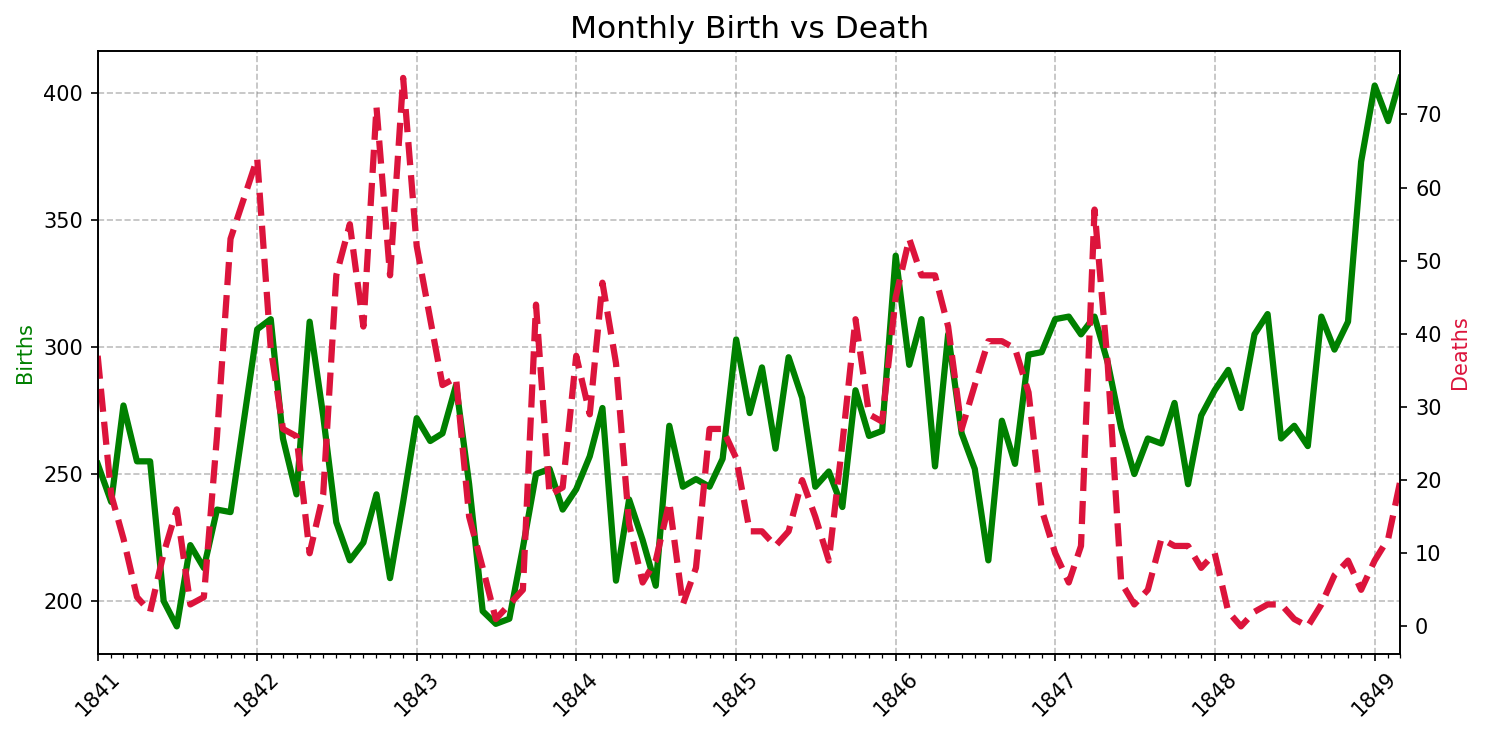

In [19]:
def explore_df(in_df: pd.DataFrame) -> None:
    print(f'DF shape: {in_df.shape}')
    print(f'DF Columns: {in_df.columns.to_list()}')

    NaN = in_df.isna().values.any()
    print(f'NaN: {NaN}')
    if NaN:
        print(f'NaN details: {in_df.isna().sum()}')
    print(f'Duplicate: {in_df.duplicated().values.any()}')

    print(f'Describe:\n{in_df.describe()}')


def gen_chart_monthly(monthly_df: pd.DataFrame) -> None:
    # locator and formatter
    years = mdates.YearLocator()
    months = mdates.MonthLocator()
    years_fmt = mdates.DateFormatter('%Y')
    
    plt.figure(
        figsize=(10, 5),
        dpi=150
    )
    plt.title('Monthly Birth vs Death', fontsize=15)
    plt.xticks(
        fontsize=10,
        rotation=45
    )
    plt.yticks(
        fontsize=10
    )

    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax1.grid(
        color='grey', 
        linestyle='--',
        alpha=0.5
    )

    ax1.set_ylabel(
        'Births',
        color='green',
        fontsize=10
    )
    ax2.set_ylabel(
        'Deaths',
        color='crimson',
        fontsize=10
    )

    ax1.set_xlim(
        monthly_df.date.min(),
        monthly_df.date.max()
    )
    
    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(years_fmt)
    ax1.xaxis.set_minor_locator(months)

    ax1.plot(
        monthly_df.date,
        monthly_df.births,
        color='green',
        linewidth=3,
        label='Births'
    )
    ax2.plot(
        monthly_df.date,
        monthly_df.deaths,
        color='crimson',
        linewidth=3,
        linestyle='--',
        label='Deaths'
    )

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    setup_logging()

    yearly_df = fetch_df('input-80-1.csv')
    monthly_df = fetch_df('input-80-2.csv')

    print('Yearly DF info')
    # explore_df(yearly_df)

    print('Monthly DF info')
    # explore_df(monthly_df)

    print(f'Monthly Avg birth: {monthly_df.births.mean()}')
    print(f'Monthly Avg deaths: {monthly_df.deaths.mean(): .2f}')

    print(f'Yearly Death during childbirth: {yearly_df.deaths.sum() / yearly_df.births.sum() * 100 : .2f}%')

    monthly_df.date = pd.to_datetime(monthly_df.date, errors='coerce')
    gen_chart_monthly(monthly_df)


# Analysing the Yearly Data Split By Clinic

In [20]:
def gen_birth_death_clinic_chart(yearly_df: pd.DataFrame) -> None:
    clinic_birth_chart = px.line(
        data_frame=yearly_df,
        x='year',
        y='births',
        color='clinic',
        title='Yearly Birth by clinics',
        markers=True,
        labels={
            'year': 'Year',
            'births': 'Number of Births',
            'clinic': 'Clinic Name'
        }
    )
    clinic_birth_chart.update_layout(
        title_font_size=15,
        legend_title_text='clinic',
        xaxis_title='Year',
        yaxis_title='Number of Births',
        template='plotly_white'
    )
    clinic_birth_chart.show()

    clinic_death_chart = px.line(
        data_frame=yearly_df,
        x='year',
        y='deaths',
        color='clinic',
        title='Yearly Death by clinics',
        markers=True,
        labels={
            'year': 'Year',
            'deaths': 'Number of Deaths',
            'clinic': 'Clinic Name'
        }
    )
    clinic_death_chart.update_layout(
        title_font_size=15,
        legend_title_text='clinic',
        xaxis_title='Year',
        yaxis_title='Number of Deaths',
        template='plotly_white'
    )
    clinic_death_chart.show()


def gen_death_pct_chart(yearly_df: pd.DataFrame) -> None:
    print(f'Clinic 1 death rate: {yearly_df[yearly_df.clinic == 'clinic 1'].deaths.sum() / yearly_df[yearly_df.clinic == 'clinic 1'].births.sum() * 100 : .2f}%')
    print(f'Clinic 2 death rate: {yearly_df[yearly_df.clinic == 'clinic 2'].deaths.sum() / yearly_df[yearly_df.clinic == 'clinic 2'].births.sum() * 100 : .2f}%')

    death_comparison = px.line(
        data_frame=yearly_df,
        x='year',
        y='death_pct',
        color='clinic',
        title='Proportion of Yearly Deaths by Clinic',
        markers=True,
        labels={
            'year': 'Year',
            'death_pct': 'Death Percentage',
            'clinic': 'Clinic Name'
        }
    )
    death_comparison.update_layout(
        title_font_size=10,
        xaxis_title='Year',
        yaxis_title='Death Rate (%)',
        yaxis_tickformat='.1%',
        template='plotly_white',
        legend_title_text='Clinic'
    )
    death_comparison.show()


if __name__ == '__main__':
    setup_logging()

    yearly_df = fetch_df('input-80-1.csv')
    monthly_df = fetch_df('input-80-2.csv')
    monthly_df.date = pd.to_datetime(monthly_df.date, errors='coerce')

    # gen_birth_death_clinic_chart(yearly_df)

    yearly_df['death_pct'] = yearly_df.deaths / yearly_df.births

    gen_death_pct_chart(yearly_df)
    

Clinic 1 death rate:  9.92%
Clinic 2 death rate:  3.88%


# The Effect of Handwashing

Avg death before 1846-07-01: 10.60%
Avg death after 1846-07-01: 4.72%


AttributeError: 'list' object has no attribute 'get_label'

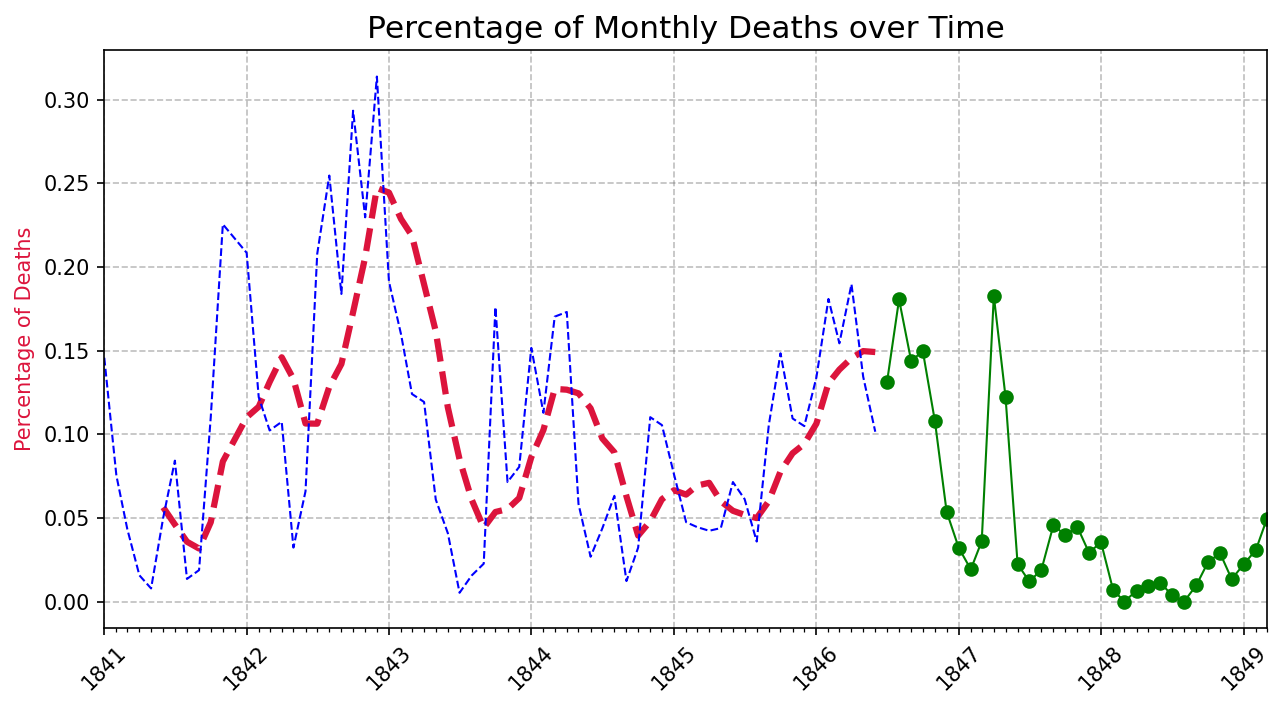

In [ ]:
if __name__ == '__main__':
    setup_logging()

    monthly_df = fetch_df('input-80-2.csv')
    monthly_df.date = pd.to_datetime(monthly_df.date, errors='coerce')

    # challenge 1
    monthly_df['death_pct'] = monthly_df.deaths / monthly_df.births

    before_wash = monthly_df[monthly_df.date < '1846-07-01']
    after_wash = monthly_df[monthly_df.date >= '1846-07-01']

    print(f'Avg death before 1846-07-01: {before_wash.deaths.sum() / before_wash.births.sum() * 100:.2f}%')
    print(f'Avg death after 1846-07-01: {after_wash.deaths.sum() / after_wash.births.sum() * 100:.2f}%')

    # challenge 2
    before_wash_rolling = before_wash.rolling(window=6, on='date').mean().set_index('date')
    # print(f'Before wash rolling avg death:\n{before_wash_rolling}')

    # challenge 3
    years = mdates.YearLocator()
    months = mdates.MonthLocator()
    years_fmt = mdates.DateFormatter('%Y')
    
    plt.figure(
        figsize=(10, 5), 
        dpi=150
    )
    plt.title('Percentage of Monthly Deaths over Time', fontsize=15)
    plt.xticks(
        fontsize=10,
        rotation=45
    )
    plt.yticks(
        fontsize=10
    )

    plt.ylabel(
        'Percentage of Deaths',
        color='crimson',
        fontsize=10
    )

    ax = plt.gca()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)

    ax.set_xlim(
        monthly_df.date.min(),
        monthly_df.date.max()
    )
    
    plt.grid(
        color='grey', 
        linestyle='--', 
        alpha=0.5
    )

    bwr_line, = plt.plot(
        before_wash_rolling.index, 
        before_wash_rolling.death_pct, 
        color='crimson', 
        linewidth=3,
        linestyle='--', 
        label='6m Moving Average'
    )
    bw_line, = plt.plot(
        before_wash.date, 
        before_wash.death_pct, 
        color='blue', 
        linewidth=1, 
        linestyle='--',
        label='Before Handwash'
    )
    aw_line, = plt.plot(
        after_wash.date, 
        after_wash.death_pct, 
        color='green', 
        linewidth=1, 
        marker='o',
        label='After Handwash'
    )
    plt.legend(
        handles=[bwr_line, bw_line, aw_line],
        fontsize=10
    )
    plt.show()
    
